[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MikeS96/cv_dl/blob/main/week4/CVDL_CONVOL_GPU.ipynb)

**Creando una primera CNN usando python, Tensorflow y Keras.
Paso 1. Cargar las librerias básicas: numpy, Tensorflow, Keras. Cargaremos tambien el dataset de ejemplo mnist.**




In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as LK #Esta clase me permite encapsular los parametros
                                     #de la capa y la transformación I/O    
import tensorflow.keras.models as MK #Esta clase me sirve para agrupar capas como un objeto.
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test,y_test)= mnist.load_data() #Este dataset ya viene dividido en train y test.


11493376/11490434 [==============================] - 0s 0us/step


In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
print('Train imagessize=%s, labelsize=%s' %(x_train.shape, y_train.shape)) #Forma antigua de imprimir con formato en python
print('Test imagessize=%s, labelsize=%s' %(x_test.shape, y_test.shape))
print("Test images size= {0} , Label size ={1}".format(x_test.shape, y_test.shape))

Train imagessize=(60000, 28, 28), labelsize=(60000,)
Test imagessize=(10000, 28, 28), labelsize=(10000,)
Test images size= (10000, 28, 28) , Label size =(10000,)


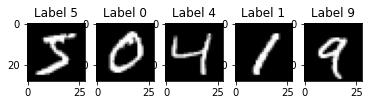

In [4]:
from matplotlib import pyplot as plt
for i in range(5): #Primeras 5 imagenes
  plt.subplot(1,5,i+1)
  plt.imshow(x_train[i], cmap='gray')
  plt.gca().set_title('Label ' + str(y_train[i])) #Podemos ver que los labels son enteros
                                                  #Muchas veces se usa el one-hot encoded
plt.show()

**Normalizacion y reshape**

El reshape sirve para obligar a que se use un solo canal en este caso.
La idea de la normalización es colocar todos los datos en la misma escala. Aqui se usará la técnica más sencilla que consiste en normalizar entre 0 y 1.

In [5]:
x_train= x_train.reshape((x_train.shape[0],28,28,1))
x_test= x_test.reshape((x_test.shape[0],28,28,1))
print("Test images size= {0} , Label size ={1}".format(x_test.shape, y_test.shape))


Test images size= (10000, 28, 28, 1) , Label size =(10000,)


In [6]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train, x_test = (x_train-x_train.min())/(x_train.max()-x_train.min()), (x_test-x_test.min())/(x_test.max()-x_test.min()) #Normaliza

In [35]:
tf.keras.backend.clear_session

<function tensorflow.python.keras.backend.clear_session>

In [36]:
from keras.optimizers import SGD
from keras.optimizers import Adam

In [37]:
def crear_modelo():
   inputs = LK.Input(shape=(28,28,1)) #Imagesnes de entrada con reshape
   conv1 = LK.Conv2D(6,(5,5),padding='same', activation='relu')(inputs) #capa de convolución: 32 filtros, f=3, p=0 y a=relu
   pool1 = LK.MaxPool2D((2,2),(2,2))(conv1) #Maxpool f=2, s=2
   conv2 = LK.Conv2D(16,(5,5),padding='valid', activation='relu')(pool1) #capa de convolución: 32 filtros, f=3, p=0 y a=relu
   pool2 = LK.MaxPool2D((2,2),(2,2))(conv2) #Maxpool f=2, s=2
   flat =  LK.Flatten()(pool2) #aplanando la salida de la capa oculta
   FC3 = LK.Dense(120,activation='relu')(flat)
   FC4 = LK.Dense(84,activation='relu')(FC3)
   outputs = LK.Dense(10,activation='softmax')(FC4) #Capa de salida con 10 nodes por ser un problema de 
   
   return MK.Model(inputs,outputs)                                           #clasificación multiclase. Función de activacion:softmax


In [38]:
estrategia = tf.device('/device:GPU:0')
optimo ='adam' #SGD(lr=0.001, momentum=0.9)#'adagrad'#Adam(lr=0.001)#'adam' #'adagrad' #SGD(lr=0.005, momentum=0.9) #0.01  0.001
with estrategia:
  model= crear_modelo() #Volviendolo un objeto.
  model.compile(optimizer=optimo, loss='sparse_categorical_crossentropy',metrics=['accuracy'] )
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 120)               4812

**Evalución del modelo**
Guardaremos la evaluación en una variable llamada ***history***

In [39]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, restore_best_weights=True)

In [40]:
history =model.fit(x_train,y_train, epochs=10, batch_size=32,validation_data=(x_test, y_test), verbose=1, callbacks = [es])
loss,acc= model.evaluate(x_test,y_test,verbose=1)
print("Loss:{0} - Accuracy:{1}".format(loss,acc) ) #Forma moderna de imprimir con formato en python


Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4424 - accuracy: 0.8534 - val_loss: 0.0689 - val_accuracy: 0.9767
Epoch 2/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0575 - accuracy: 0.9817 - val_loss: 0.0405 - val_accuracy: 0.9876
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0392 - accuracy: 0.9878 - val_loss: 0.0358 - val_accuracy: 0.9875
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0310 - accuracy: 0.9892 - val_loss: 0.0367 - val_accuracy: 0.9883
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0258 - accuracy: 0.9916 - val_loss: 0.0318 - val_accuracy: 0.9895
Epoch 6/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0198 - accuracy: 0.9939 - val_loss: 0.0345 - val_accuracy: 0.9894
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0155 - accuracy: 0.9950 - val_loss: 0.0312 - val_accuracy:

**Visualización**
Graficaremos el ***accuracy*** tanto para los datos de ***train*** como para los datos de ***test***.

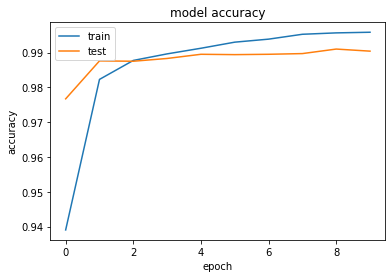

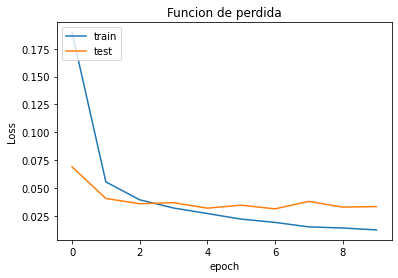

In [41]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Funcion de perdida')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [42]:
import cv2
from matplotlib import pyplot as plt
from keras.preprocessing.image import img_to_array
model.save('mnistown.h5')
from keras.models import load_model
modelo= load_model('mnistown.h5')
etiquetas = ['cero', 'uno', 'dos', 'tres', 'cuatro', 'cinco', 'seis', 'siete', 'ocho', 'nueve']

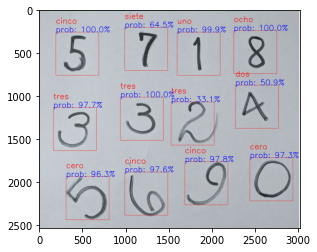

In [43]:
im = cv2.imread('real_hw.jpg')

imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(imgray,(5,5),0)
ret, thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
kernel = np.ones((45,45),np.uint8)
kernel2 = np.ones((5,5),np.uint8)
erosion = cv2.erode(thresh ,kernel2,iterations = 2)
dilation = cv2.dilate(erosion,kernel,iterations = 1)
contours, hierarchy = cv2.findContours(dilation,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for c in contours:
    (x, y), radius = cv2.minEnclosingCircle(c)
    w=250
    h= 250
    cv2.rectangle(im, (int(x)-w, int(y)-h), (int(x)+w, int(y)+h), (255, 0, 0), 2)
    crop_img = dilation[int(y)-h:int(y)+h, int(x)-w:int(x)+w]
    crop_img_r = cv2.resize(crop_img, (28,28), interpolation = cv2.INTER_LINEAR)
    
    crop_img_r.reshape((-1,28,28,1))
    crop_img_ra = img_to_array(crop_img_r)
    crop_img_ra = np.expand_dims(crop_img_ra, axis=0)
    crop_img_ra = crop_img_ra.astype('float32')
    crop_img_ra = crop_img_ra/255.0
    resultado = modelo.predict(crop_img_ra)
    
    cv2.putText(im, 
                str(etiquetas[(np.argmax(resultado,axis=1))[0]]) , (int(x)-w,int(y)-h-100), cv2.FONT_HERSHEY_SIMPLEX ,  
                   3, (255,0,0), 4, cv2.LINE_AA) 
    cv2.putText(im, 
                "prob: " + str(round(np.max(resultado)*100,1)) + "%", (int(x)-w,int(y)-h), cv2.FONT_HERSHEY_SIMPLEX ,  
                   3, (0,0,255), 4, cv2.LINE_AA) 
plt.imshow(im)
plt.show()